# EMOTION RECOGNITION USING LSTM
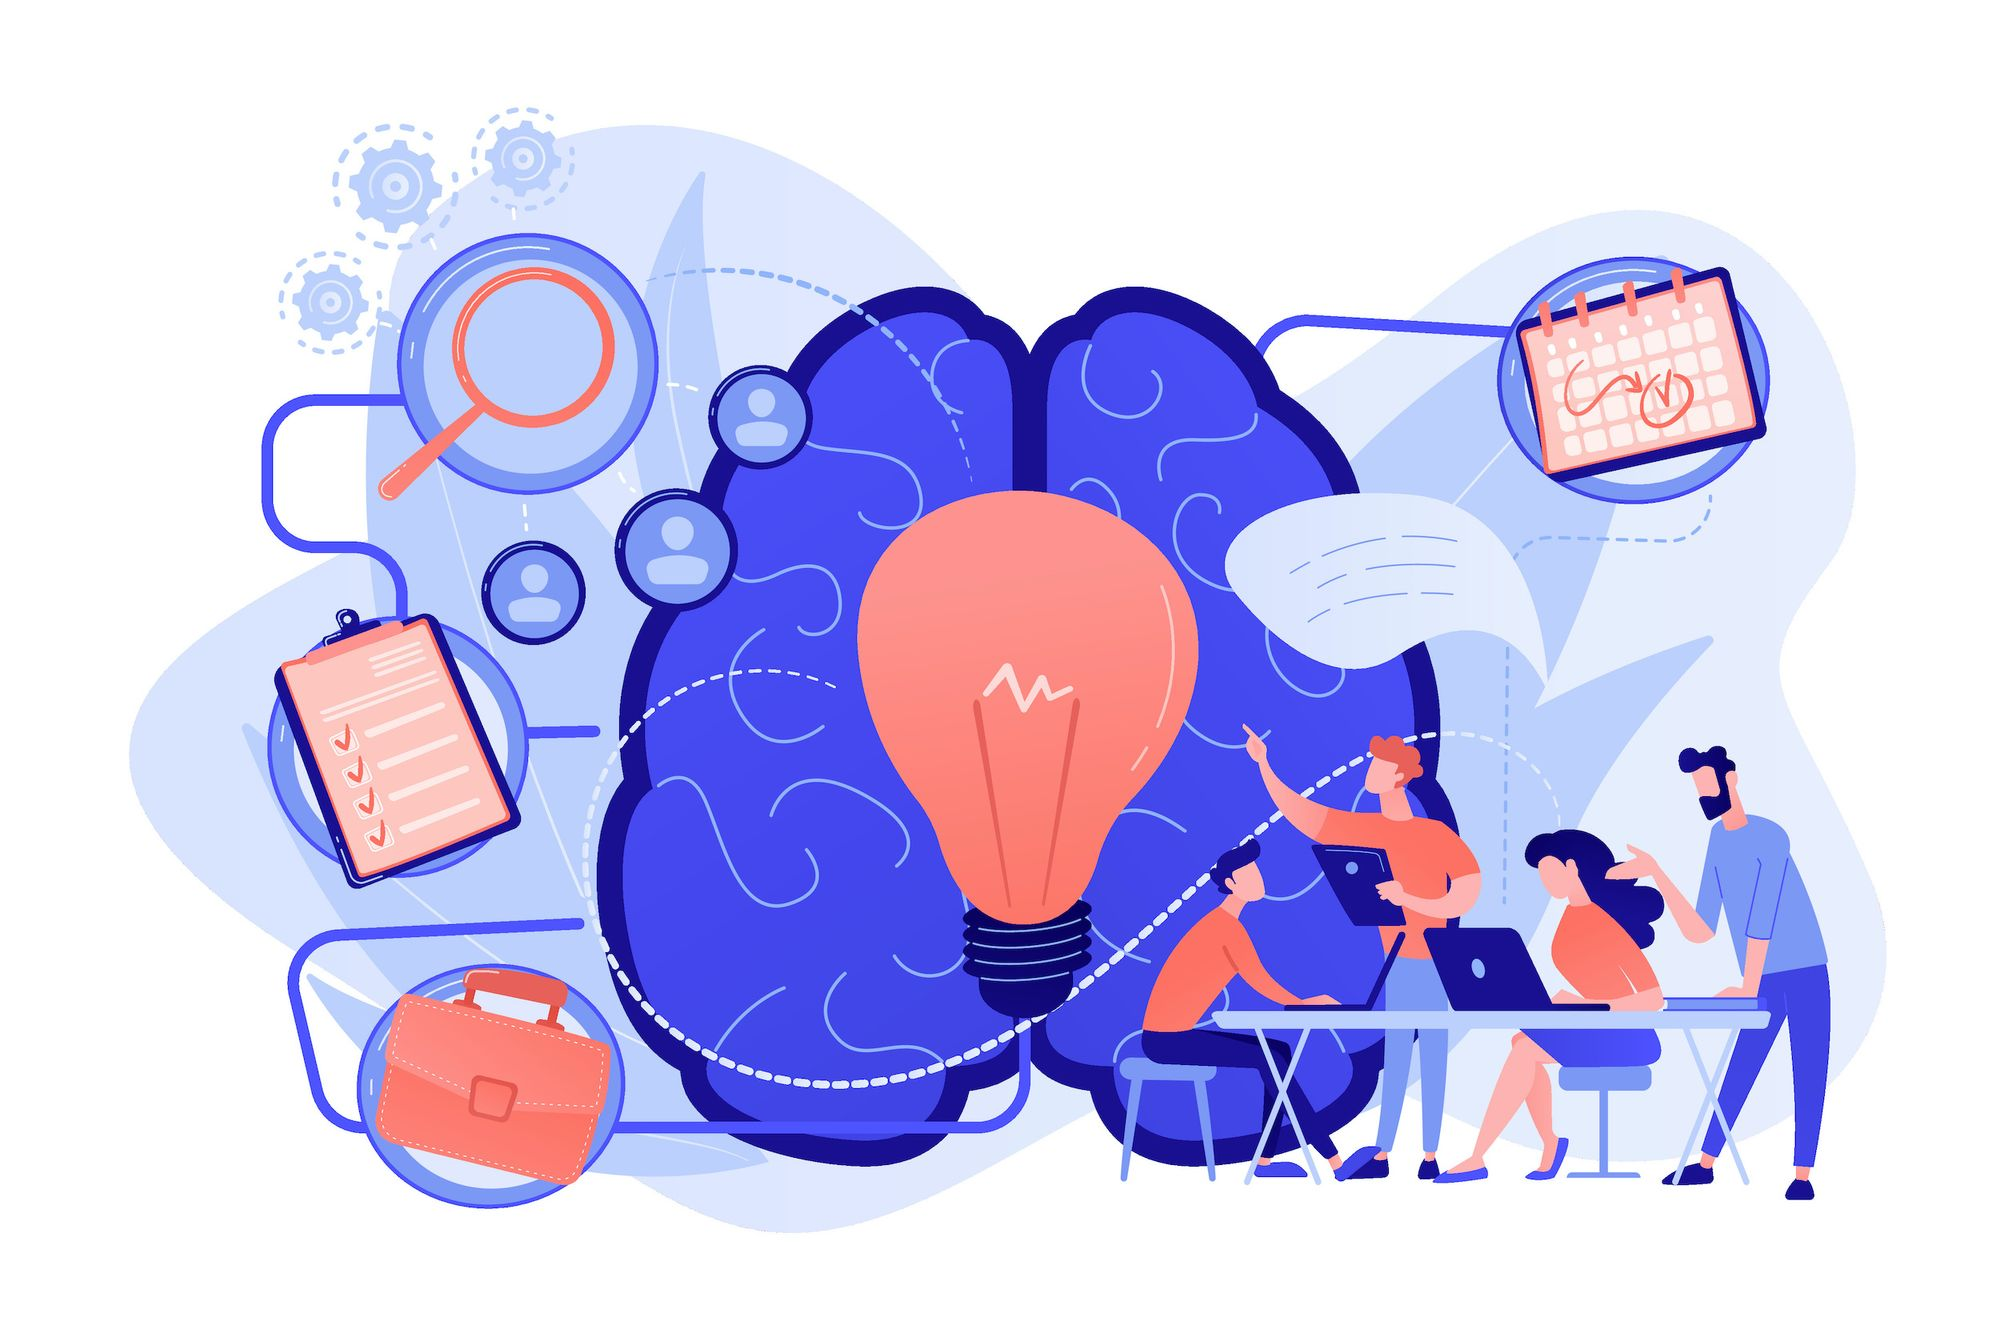

1) Overview : Explore text-based emotion recognition, a dynamic field in NLP, focusing on deciphering diverse emotional states in textual content.

2) Objective : Build a system for automatic categorization of text into six emotions ( joy , sadness , fear , anger , love , surprise)

3) Model Choice : Utilize LSTM (Long Short-Term Memory) networks, a type of RNN.

4) Implementation : Implemented with TensorFlow.

# Importing all the required modules and libraries.

In [11]:
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
from nltk.stem import PorterStemmer
import numpy as np
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix


import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

# 1) The Dataset
This is a kaggle data set by the name "Emotion Dataset for emotion recognition tasks".
A BRIEF DESCIPTION : A dataset of English Twitter messages with six basic emotions: anger, fear, joy, love, sadness, and surprise.


Any data involving sentiment analysis is a Binary Classification Problem. In this dataset, we have 6 different classes , so we will be treating the above problem as a multi-class classification Problem.

In [13]:
val_data = pd.read_csv('VALIDATION.csv')
train_data = pd.read_csv('TRAINING.csv')
test_data = pd.read_csv('TEST.csv')

In [14]:
print("Validation data :",val_data.shape)
print("Train data :",train_data.shape)
print("Test data :",test_data.shape)


Validation data : (2000, 2)
Train data : (16000, 2)
Test data : (2000, 2)


There was a lot of data in the Testing file so I transferred some of it to the Validation Set.

In [15]:
half_test_data = test_data.iloc[1000:]
test_data = test_data.iloc[:1000]

val_data = pd.concat([val_data, half_test_data], axis=0)

print("new Vald data :",val_data.shape)
print("new Test data :",test_data.shape)

new Vald data : (3000, 2)
new Test data : (1000, 2)


In [16]:
train_data.head(10)

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3
5,ive been feeling a little burdened lately wasn...,0
6,ive been taking or milligrams or times recomme...,5
7,i feel as confused about life as a teenager or...,4
8,i have been with petronas for years i feel tha...,1
9,i feel romantic too,2


Adding Labels To thr Data.

In [17]:
labels_dict = {0:'sadness', 1:'joy', 2:'love', 3:'anger', 4:'fear', 5:'surprise'}
train_data['label_name'] = train_data['label'].map(labels_dict)
train_data.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


In [18]:
labels_dict = {0:'sadness', 1:'joy', 2:'love', 3:'anger', 4:'fear', 5:'surprise'}
train_data['label_name'] = train_data['label'].map(labels_dict)
train_data.head()


,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


In [19]:
train_data.groupby(["label_name","label"]).size()

label_name  label
anger       3        2159
fear        4        1937
joy         1        5362
love        2        1304
sadness     0        4666
surprise    5         572
dtype: int64

Data Visualization.

<Axes: xlabel='label_name'>

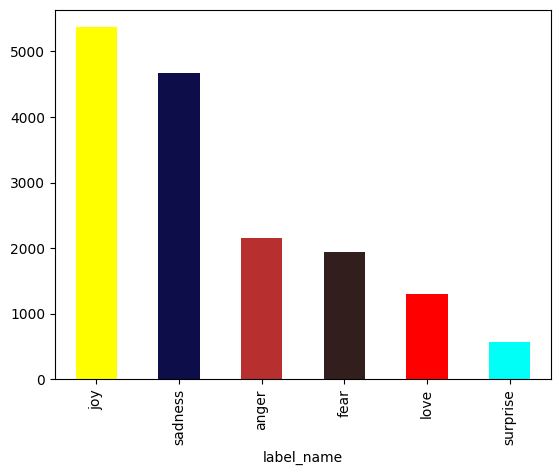

In [20]:
train_data["label_name"].value_counts().plot(kind='bar',color=['yellow', '#0c0d49', '#b82f2f', '#331e1e', 'red','#00fff7'])

# 2) DATA CLEANING

As it is a Kaggle Dataset the Data is already pre-processed But we will still check for NULL values. 

In [21]:
print(train_data.isnull().sum())
print(val_data.isnull().sum())
print(test_data.isnull().sum())

text          0
label         0
label_name    0
dtype: int64
text     0
label    0
dtype: int64
text     0
label    0
dtype: int64


# 3) Tokenization and Stemming
Tokenization assigns unique IDs to words, creating a word index or vocabulary.

Example :
Sentence : "Tokenization is essential for NLP tasks."
Tokenized Output : ['Tokenization', 'is', 'essential', 'for', 'NLP', 'tasks', '.']

Stemming is a technique used to reduce an inflected word down to its word stem.

Example :
Original Words : running , programming , swimming , happiness , programmer (5 words)
Stemmed Words : run , program , swim , happi (4 words)

In [22]:
all_list = train_data['text'].tolist() + test_data['text'].tolist() + val_data['text'].tolist()

In [24]:
tokenizer1 = Tokenizer()
tokenizer1.fit_on_texts(all_list)
word_index1 = tokenizer1.word_index

print("Number of words without Stemming:",len(word_index1))

stemmer = PorterStemmer()
stemmed_words = [stemmer.stem(word) for word in word_index1.keys()]

tokenizer2 = Tokenizer()
tokenizer2.fit_on_texts(stemmed_words)
word_index2 = tokenizer2.word_index

print("Number of words with Stemming:",len(word_index2))

Number of words without Stemming: 17096
Number of words with Stemming: 11705


Load all data to list [ [ Tokenized_data ] ,label ].

In [25]:
def preprocess_data(data):
    new_data = []
    for index, row in data.iterrows():
        test_split = row['text'].split()
        stemmed_words2 = [stemmer.stem(word) for word in test_split]
        token_list= tokenizer2.texts_to_sequences([stemmed_words2])[0]
        new_data.append([token_list,row['label']]) 
    return new_data

In [26]:
train_data.groupby(["label_name","label"]).size()

label_name  label
anger       3        2159
fear        4        1937
joy         1        5362
love        2        1304
sadness     0        4666
surprise    5         572
dtype: int64

In [27]:
new_train_data = preprocess_data(train_data)
print(train_data['text'][0])
print(new_train_data[0])    

i didnt feel humiliated
[[3198, 3265, 220, 665], 0]


In [28]:
new_val_data = preprocess_data(val_data)
print(val_data['text'][0])
print(new_val_data[0])    

im feeling quite sad and sorry for myself but ill snap out of it soon
[[3205, 220, 595, 1335, 3199, 3326, 3206, 3227, 3207, 1326, 518, 1283, 1274, 1276, 3380], 0]


In [29]:
# Splitting into train_X and train_y
train_X = [row[0] for row in new_train_data]
train_y = [row[1] for row in new_train_data]

# Print the results
print("train_X:", train_X[0])
print("train_y:", train_y[0])

train_X: [3198, 3265, 220, 665]
train_y: 0


In [30]:
val_X = [row[0] for row in new_val_data]
val_y = [row[1] for row in new_val_data]

print("train_X:", val_X[0])
print("train_y:", val_y[0])

train_X: [3205, 220, 595, 1335, 3199, 3326, 3206, 3227, 3207, 1326, 518, 1283, 1274, 1276, 3380]
train_y: 0


Add Padding.

In [31]:
length_of_longest_sentence = len(max(train_X, key=len))
print(length_of_longest_sentence)
print(max(train_X, key=len))

66
[3198, 613, 3250, 3588, 3217, 3204, 3198, 927, 3245, 1497, 3245, 1354, 3217, 3245, 1303, 1296, 3200, 2107, 1284, 1276, 3220, 220, 3598, 3213, 220, 1276, 3528, 3217, 7890, 4263, 3221, 5569, 1552, 3243, 3198, 4263, 3221, 1552, 5570, 5570, 3198, 3579, 5569, 3198, 7891, 1276, 3200, 3202, 1293, 3219, 1401, 3948, 3598, 3213, 3223, 239, 3528, 3213, 85, 3267, 579, 1658, 3206, 3201, 239, 1289]


In [32]:
for i in range(len(train_X)):
    for j in range(length_of_longest_sentence-len(train_X[i])):
        train_X[i].append(0)
        
for i in range(len(val_X)):
    for j in range(length_of_longest_sentence-len(val_X[i])):
        val_X[i].append(0)

In [33]:
train_X = np.array(train_X)
train_y = np.array(train_y)
val_X = np.array(val_X)
val_y = np.array(val_y)

print(train_X.shape,train_y.shape)
print(val_X.shape,val_y.shape)

(16000, 66) (16000,)
(3000, 66) (3000,)


One Hot-Encoding

In [34]:
# Convert labels to one-hot encoding
train_y_one_hot = to_categorical(train_y, num_classes=16000)
val_y_one_hot = to_categorical(val_y, num_classes=16000)

# 4) Create the Model



Bi-LSTM Neural Network Training

In [35]:
model = Sequential()
model.add(Embedding(16000, 100, input_length=66))
model.add(Bidirectional(LSTM(150)))
model.add(Dense(16000, activation='softmax'))
adam = Adam(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
history = model.fit(train_X, train_y_one_hot, epochs=25, verbose=1,validation_data=(val_X,val_y_one_hot))
#print model.summary()
print(model)

Epoch 1/25
500/500 [==============================] - 180s 347ms/step - loss: 1.8316 - accuracy: 0.3192 - val_loss: 1.5934 - val_accuracy: 0.3540
Epoch 2/25
500/500 [==============================] - 162s 324ms/step - loss: 1.5968 - accuracy: 0.3152 - val_loss: 1.5860 - val_accuracy: 0.3540
Epoch 3/25
500/500 [==============================] - 167s 333ms/step - loss: 1.5913 - accuracy: 0.3192 - val_loss: 1.5729 - val_accuracy: 0.3540
Epoch 4/25
500/500 [==============================] - 152s 304ms/step - loss: 1.5859 - accuracy: 0.3272 - val_loss: 1.5787 - val_accuracy: 0.3413
Epoch 5/25
500/500 [==============================] - 167s 334ms/step - loss: 1.5699 - accuracy: 0.3384 - val_loss: 1.5603 - val_accuracy: 0.3560
Epoch 6/25
500/500 [==============================] - 174s 348ms/step - loss: 1.3352 - accuracy: 0.4747 - val_loss: 1.0705 - val_accuracy: 0.5807
Epoch 7/25
500/500 [==============================] - 168s 337ms/step - loss: 0.7552 - accuracy: 0.6963 - val_loss: 0.6580 -

# 5) Results and Tests

In [36]:
last_accuracy = "{:.3f}".format(history.history['accuracy'][-1])
print("Training Accuracy:", last_accuracy)

Training Accuracy: 0.993


Accuracy plots for Training vs Validation Sets.

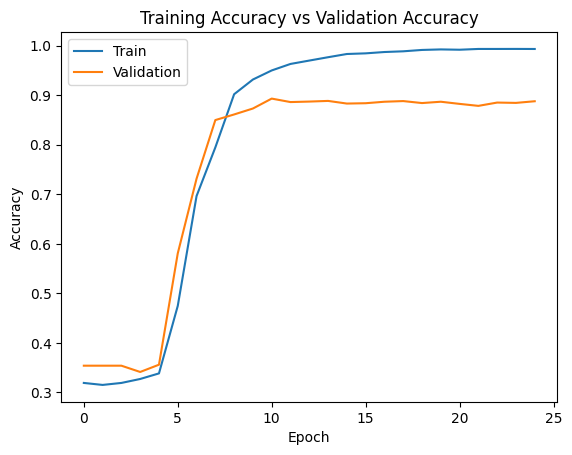

In [37]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training Accuracy vs Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


Loss Plot for Training and Validation Set.

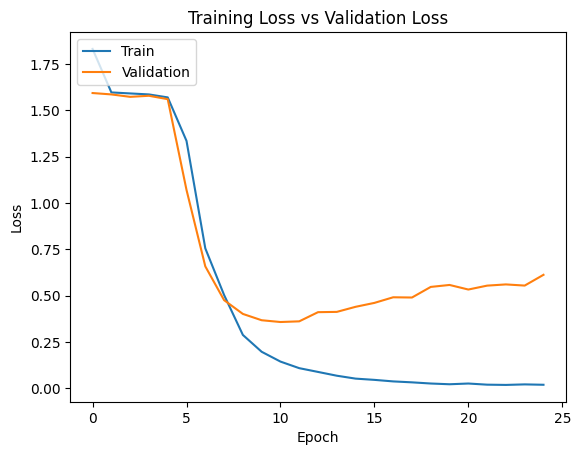

In [38]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training Loss vs Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Testing the Model.

In [39]:
def get_text(text):
    tokenizer3 = Tokenizer()
    tokenizer3.fit_on_texts(text)
    word_index3 = tokenizer3.word_index
    
    stemmed_wordss = [stemmer.stem(word) for word in word_index3.keys()]
   
    tokens_list= tokenizer2.texts_to_sequences([stemmed_wordss])[0]

    for i in range(len(tokens_list)):
        for j in range(length_of_longest_sentence-len(tokens_list)):
            tokens_list.append(0)
    return tokens_list

In [40]:
 for _ in range(5):
    random_number = random.randint(0, 1000)
    num_to_predicte = random_number
    sentence=test_data['text'][num_to_predicte]
    test = get_text([test_data['text'][num_to_predicte]])

    test = np.array(test)
    test = test.reshape(1, len(test))

    # Make predictions
    predictions = model.predict(test)

    predicted_class = np.argmax(predictions)
    print()
    print('Random sentence = ', sentence)
    print("Predicted Class:", predicted_class,labels_dict.get(predicted_class))
    print("Actual Class:", test_data['label'][num_to_predicte])
    print()

1/1 [==============================] - 2s 2s/step

Random sentence =  i feel so scared when the voices from there start to speak to me
Predicted Class: 4 fear
Actual Class: 4

1/1 [==============================] - 0s 47ms/step

Random sentence =  i no longer feel doomed to falling into the abyss with no way out
Predicted Class: 0 sadness
Actual Class: 0

1/1 [==============================] - 0s 52ms/step

Random sentence =  i feel as if we have a talented enough team to win some games and go deep into the tournament
Predicted Class: 1 joy
Actual Class: 1

1/1 [==============================] - 0s 55ms/step

Random sentence =  i imagined being in form fitting clothing that was beautiful looking in the mirror and feeling proud being lighter and more energetic
Predicted Class: 1 joy
Actual Class: 1

1/1 [==============================] - 0s 66ms/step

Random sentence =  i am going to have to check on in just a few minutes but there is this clock up above the screen that keeps ticking do

Confusion Matrix

In [41]:
new_test_data=preprocess_data(test_data)

test_X = [row[0] for row in new_train_data]
test_y = [row[1] for row in new_train_data]

for i in range(len(test_X)):
    for j in range(length_of_longest_sentence-len(test_X[i])):
        test_X[i].append(0)
        
test_X = np.array(test_X) 
test_y = np.array(test_y)  

test_y_one_hot = to_categorical(test_y, num_classes=16000)

In [42]:
y_pred = model.predict(test_X)
y_pred_classes = np.argmax(y_pred, axis=1)

500/500 [==============================] - 24s 47ms/step


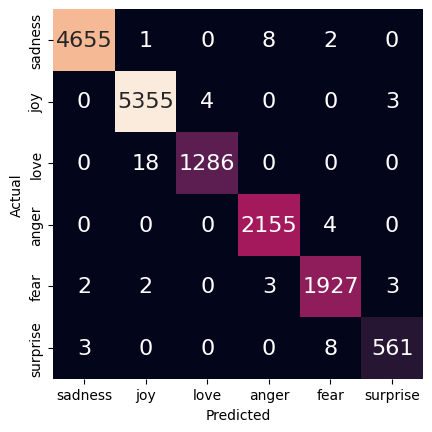

In [43]:
y_true_labels = np.argmax(test_y_one_hot, axis=1)

labels=['sadness','joy','love','anger','fear','surprise']
#labels = list(set(labels).intersection(set(np.unique(y_true_labels)).union(set(np.unique(y_pred_classes)))))

cm = confusion_matrix(y_true_labels, y_pred_classes)
df_cm = pd.DataFrame(cm, labels, labels)
ax = sns.heatmap(df_cm, annot=True, annot_kws={'size': 16}, square=True, cbar=False, fmt='g')
ax.set_ylim(0, 6) 
plt.xlabel('Predicted') 
plt.ylabel('Actual') 
ax.invert_yaxis() 
plt.show()